In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE')

In [ ]:
# === ИМПОРТЫ И НАСТРОЙКИ ===
import numpy as np
import pandas as pd
import os
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, average_precision_score, matthews_corrcoef,
    accuracy_score, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest
import lightgbm as lgb

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("=== ПАЙПЛАЙН С РАСШИРЕННЫМИ МЕТРИКАМИ ===")


=== ПАЙПЛАЙН С РАСШИРЕННЫМИ МЕТРИКАМИ ===


In [ ]:
# === ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ МЕТРИК ===
def safe_auc(y_true, y_score):
    """AUC падает, если в y_true один класс."""
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_score)

def safe_ap(y_true, y_score):
    """AP тоже требует 2 класса, иначе NaN."""
    if len(np.unique(y_true)) < 2:
        return np.nan
    return average_precision_score(y_true, y_score)

def compute_metrics(y_true, y_proba, threshold):
    """
    Расширенные метрики.
    threshold влияет на pred-метрики; AUC/AP не зависят от threshold.
    """
    y_pred = (y_proba >= threshold).astype(int)

    # confusion matrix: [[tn, fp],[fn,tp]]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = np.nan

    specificity = tn / (tn + fp) if (tn + fp) not in [0, np.nan] else 0.0

    metrics = {
        "AUC": safe_auc(y_true, y_proba),
        "AP": safe_ap(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred) if len(y_true) else np.nan,
        "F1": f1_score(y_true, y_pred, zero_division=0) if len(y_true) else np.nan,
        "Recall": recall_score(y_true, y_pred, zero_division=0) if len(y_true) else np.nan,
        "Precision": precision_score(y_true, y_pred, zero_division=0) if len(y_true) else np.nan,
        "Specificity": specificity,
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else np.nan,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }
    return metrics

def print_split_metrics(split_name, metrics_dict):
    """
    Красивый вывод метрик для одного сплита (train/val/test).
    """
    def fmt(x):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return "nan"
        if isinstance(x, (int, np.integer)):
            return str(int(x))
        return f"{x:.3f}"

    print(f"   [{split_name}] "
          f"AUC={fmt(metrics_dict['AUC'])}  AP={fmt(metrics_dict['AP'])}  "
          f"Acc={fmt(metrics_dict['Accuracy'])}  F1={fmt(metrics_dict['F1'])}  "
          f"Rec={fmt(metrics_dict['Recall'])}  Prec={fmt(metrics_dict['Precision'])}  "
          f"Spec={fmt(metrics_dict['Specificity'])}  BalAcc={fmt(metrics_dict['BalancedAcc'])}   "
          f"CM(TN,FP,FN,TP)=({fmt(metrics_dict['TN'])},{fmt(metrics_dict['FP'])},"
          f"{fmt(metrics_dict['FN'])},{fmt(metrics_dict['TP'])})"
    )


In [ ]:
# === ФУНКЦИЯ ЗАГРУЗКИ ДАННЫХ ===
def load_and_align_data():
    """
    Загрузка данных с гарантией совпадения размеров
    """
    print("1. Загрузка и выравнивание данных...")

    subject_ids_path = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality/subject_IDs.txt'
    pheno_path = '/content/drive/MyDrive/ABIDE/phenotypic.csv'
    aal_path = '/content/drive/MyDrive/ABIDE/AAL/original/'

    if os.path.exists(subject_ids_path):
        subject_IDs = np.genfromtxt(subject_ids_path, dtype=str)
    else:
        print("ВНИМАНИЕ: Файл с ID не найден, создаем тестовые данные...")
        subject_IDs = [f"{i:05d}" for i in range(50001, 50101)]

    if os.path.exists(pheno_path):
        pheno_df = pd.read_csv(pheno_path)
    else:
        print("ВНИМАНИЕ: Фенотипические данные не найдены, создаем тестовые...")
        pheno_df = pd.DataFrame({
            'SUB_ID': [int(sid) for sid in subject_IDs],
            'DX_GROUP': np.random.choice([1, 2], size=len(subject_IDs), p=[0.5, 0.5]),
            'SITE_ID': np.random.choice(['SITE_01', 'SITE_02', 'SITE_03'], size=len(subject_IDs)),
            'AGE_AT_SCAN': np.random.uniform(6, 18, size=len(subject_IDs)),
            'SEX': np.random.choice(['M', 'F'], size=len(subject_IDs), p=[0.7, 0.3])
        })

    matrices = []
    meta_data = []

    for sid in subject_IDs:
        mat_path = os.path.join(aal_path, f"{sid}.mat")
        if os.path.exists(mat_path):
            try:
                mat = sio.loadmat(mat_path)
                if 'connectivity' not in mat:
                    continue
                conn = mat['connectivity']
                if conn.shape[0] != conn.shape[1]:
                    continue

                triu_idx = np.triu_indices_from(conn, k=1)
                features = conn[triu_idx]

                if np.any(np.isnan(features)) or np.any(np.isinf(features)):
                    continue

                matrices.append(features)

                sub_info = pheno_df[pheno_df['SUB_ID'] == int(sid)]
                if len(sub_info) > 0:
                    meta_data.append({
                        'subject_id': sid,
                        'site': sub_info['SITE_ID'].values[0],
                        'age': sub_info['AGE_AT_SCAN'].values[0],
                        'sex': 1 if sub_info['SEX'].values[0] == 'M' else 0,
                        'diagnosis': 1 if sub_info['DX_GROUP'].values[0] == 1 else 0
                    })
                else:
                    matrices.pop()
            except Exception:
                continue

    min_len = min(len(matrices), len(meta_data))
    matrices = matrices[:min_len]
    meta_data = meta_data[:min_len]

    X = np.array(matrices)
    y = np.array([m['diagnosis'] for m in meta_data])
    sites = np.array([m['site'] for m in meta_data])
    ages = np.array([m['age'] for m in meta_data])
    sexes = np.array([m['sex'] for m in meta_data])
    subject_ids = np.array([m['subject_id'] for m in meta_data])

    print(f"   Загружено: X={X.shape}, y={y.shape}, sites={sites.shape}")
    print(f"   Классы: ASD={sum(y)} ({sum(y)/len(y)*100:.1f}%), "
          f"Control={len(y)-sum(y)} ({(1-sum(y)/len(y))*100:.1f}%)")

    return X, y, sites, ages, sexes, subject_ids

In [ ]:
# === ЯЧЕЙКА 4: ВИЗУАЛИЗАЦИЯ СТАТИСТИКИ ДАННЫХ (БЕЗ ГРАФИКА ПО ПОЛУ) ===
def visualize_data_statistics(X, y, sites, ages, sexes):
    """
    Создание графиков со статистикой данных (без распределения по полу)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Распределение классов
    class_counts = pd.Series(y).value_counts()
    class_labels = ['Control (0)', 'ASD (1)']
    axes[0, 0].bar(class_labels[:len(class_counts)], class_counts.values,
                   color=['skyblue', 'salmon'])
    axes[0, 0].set_title('Распределение классов')
    axes[0, 0].set_ylabel('Количество')
    for i, v in enumerate(class_counts.values):
        axes[0, 0].text(i, v + 2, str(v), ha='center')

    # 2. Распределение по центрам (топ-10)
    site_counts = pd.Series(sites).value_counts().head(10)
    if len(site_counts) > 0:
        axes[0, 1].barh(range(len(site_counts)), site_counts.values)
        axes[0, 1].set_yticks(range(len(site_counts)))
        axes[0, 1].set_yticklabels(site_counts.index)
        axes[0, 1].set_title(f'Топ-{min(10, len(site_counts))} центров сбора данных')
    else:
        axes[0, 1].text(0.5, 0.5, 'Нет данных о центрах',
                       ha='center', va='center', fontsize=12)
    axes[0, 1].set_xlabel('Количество участников')

    # 3. Распределение возраста
    if len(ages) > 0:
        axes[0, 2].hist(ages, bins=15, edgecolor='black', alpha=0.7)
        axes[0, 2].set_title('Распределение возраста')
        axes[0, 2].set_xlabel('Возраст (лет)')
        axes[0, 2].set_ylabel('Частота')
    else:
        axes[0, 2].text(0.5, 0.5, 'Нет данных о возрасте',
                       ha='center', va='center', fontsize=12)

    # 4. ПРОПУСКАЕМ график распределения по полу (убрали проблемный код)
    # Вместо него покажем соотношение признаков в данных
    axes[1, 0].barh(['Признаки', 'Образцы', 'Отношение'],
                   [X.shape[1], X.shape[0], X.shape[1]/X.shape[0]],
                   color=['lightgreen', 'lightcoral', 'gold'])
    axes[1, 0].set_title('Размерность данных')
    axes[1, 0].set_xlabel('Значение')

    # Добавим числовые значения на столбцы
    for i, (label, value) in enumerate(zip(['Признаки', 'Образцы', 'Отношение'],
                                          [X.shape[1], X.shape[0], X.shape[1]/X.shape[0]])):
        axes[1, 0].text(value + max([X.shape[1], X.shape[0]]) * 0.02, i,
                       f'{value:.1f}' if isinstance(value, float) else str(value),
                       va='center', fontsize=10)

    # 5. Баланс классов в процентах
    asd_percent = sum(y) / len(y) * 100
    control_percent = 100 - asd_percent
    balance_labels = [f'ASD\n{asd_percent:.1f}%', f'Control\n{control_percent:.1f}%']
    axes[1, 1].pie([asd_percent, control_percent], labels=balance_labels,
                   colors=['salmon', 'skyblue'], autopct='')
    axes[1, 1].set_title('Баланс классов (%)')

    # 6. Гистограмма силы связей (случайная выборка 1000 связей)
    if X.shape[1] > 1000:
        # Берем случайную выборку для ускорения
        sample_indices = np.random.choice(X.shape[1], 1000, replace=False)
        sample_data = X[:, sample_indices].flatten()
    else:
        sample_data = X.flatten()

    axes[1, 2].hist(sample_data, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 2].set_title('Распределение значений связности')
    axes[1, 2].set_xlabel('Значение коэффициента корреляции')
    axes[1, 2].set_ylabel('Частота')

    plt.tight_layout()
    plt.savefig('data_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Дополнительная текстовая статистика
    print("\n" + "="*60)
    print("СТАТИСТИКА ДАННЫХ:")
    print("="*60)
    print(f"Общее количество образцов: {X.shape[0]}")
    print(f"Общее количество признаков: {X.shape[1]}")
    print(f"Отношение признаков к образцам: {X.shape[1]/X.shape[0]:.3f}")
    print(f"Класс ASD: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Класс Control: {len(y)-sum(y)} ({(1-sum(y)/len(y))*100:.1f}%)")

    if len(np.unique(sites)) > 0:
        print(f"Количество уникальных центров: {len(np.unique(sites))}")

    if len(ages) > 0:
        print(f"Возраст: {np.min(ages):.1f} - {np.max(ages):.1f} лет")
        print(f"Средний возраст: {np.mean(ages):.1f} ± {np.std(ages):.1f} лет")


    return fig

In [ ]:
# === СТАБИЛЬНЫЙ ОТБОР ПРИЗНАКОВ ===
def stable_feature_selection_cv_fold(X_train, y_train, sites_train, n_features=60, random_state=42):
    """
    Стабильный отбор признаков ТОЛЬКО на тренировочных данных одного фолда
    """
    print(f"   Отбор признаков (цель: {n_features})...")

    inner_sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=random_state)
    feature_selection_matrix = np.zeros((X_train.shape[1], 3))

    fold_num = 0
    for inner_train_idx, inner_val_idx in inner_sgkf.split(X_train, y_train, groups=sites_train):
        X_inner_train = X_train[inner_train_idx]
        y_inner_train = y_train[inner_train_idx]
        X_inner_val = X_train[inner_val_idx]
        y_inner_val = y_train[inner_val_idx]

        scaler = StandardScaler()
        X_inner_train_scaled = scaler.fit_transform(X_inner_train)
        X_inner_val_scaled = scaler.transform(X_inner_val)

        models = [
            LogisticRegression(penalty='l1', C=0.005, solver='saga',
                              max_iter=2000, random_state=random_state + fold_num * 10),
            LogisticRegression(penalty='l2', C=0.01, solver='saga',
                              max_iter=2000, random_state=random_state + fold_num * 10 + 100),
            LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=0.01,
                              solver='saga', max_iter=2000,
                              random_state=random_state + fold_num * 10 + 200)
        ]

        fold_feature_scores = np.zeros(X_train.shape[1])

        for model in models:
            model.fit(X_inner_train_scaled, y_inner_train)
            fold_feature_scores += np.abs(model.coef_[0])

            y_pred = model.predict_proba(X_inner_val_scaled)[:, 1]
            auc = safe_auc(y_inner_val, y_pred)
            if not np.isnan(auc):
                fold_feature_scores += (auc * np.abs(model.coef_[0]))

        feature_selection_matrix[:, fold_num] = fold_feature_scores
        fold_num += 1

    mean_scores = np.mean(feature_selection_matrix, axis=1)
    std_scores = np.std(feature_selection_matrix, axis=1)

    stability_scores = mean_scores / (std_scores + 1e-10)

    if len(stability_scores) > 0:
        stability_threshold = np.percentile(stability_scores, 90)
        stable_mask = stability_scores >= stability_threshold

        if np.sum(stable_mask) > n_features:
            top_stable_idx = np.argsort(mean_scores[stable_mask])[-n_features:]
            selected_indices = np.where(stable_mask)[0][top_stable_idx]
        elif np.sum(stable_mask) > 0:
            selected_indices = np.where(stable_mask)[0]
        else:
            selected_indices = np.argsort(mean_scores)[-n_features:]
    else:
        selected_indices = np.arange(X_train.shape[1])[:min(n_features, X_train.shape[1])]

    if len(selected_indices) > 1:
        X_selected_temp = X_train[:, selected_indices]
        if X_selected_temp.shape[0] > 1:
            corr = np.abs(np.corrcoef(X_selected_temp, rowvar=False))
            if corr.shape[0] > 1:
                high_corr_mask = np.any(np.triu(corr, 1) > 0.85, axis=0)
                final_indices = selected_indices[~high_corr_mask]
                if len(final_indices) == 0:
                    final_indices = selected_indices
            else:
                final_indices = selected_indices
        else:
            final_indices = selected_indices
    else:
        final_indices = selected_indices

    if len(final_indices) > n_features:
        final_indices = final_indices[:n_features]

    print(f"   Итоговое количество признаков: {len(final_indices)}")
    return final_indices

# === ЯЧЕЙКА 6: МОДЕЛИ ===
def create_ultra_regularized_logistic_regression(X_train, y_train, random_state=42):
    print("   Обучение СИЛЬНО регуляризованной Logistic Regression...")

    param_grid = {
        'C': [0.0001, 0.001, 0.005, 0.01],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'class_weight': ['balanced'],
        'solver': ['saga']
    }

    base = LogisticRegression(max_iter=3000, random_state=random_state)

    grid_search = GridSearchCV(
        base,
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)

    calibrated_model = CalibratedClassifierCV(
        grid_search.best_estimator_,
        method='sigmoid',
        cv=3
    )
    calibrated_model.fit(X_train, y_train)
    return calibrated_model

def create_ultra_regularized_lightgbm(X_train, y_train, X_val, y_val, random_state=42):
    print("   Обучение СИЛЬНО регуляризованного LightGBM...")

    pos = np.sum(y_train == 1)
    neg = np.sum(y_train == 0)
    scale_pos_weight = (neg / pos) if pos > 0 else 1

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 8,
        'max_depth': 3,
        'learning_rate': 0.01,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 1,
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'min_child_samples': 30,
        'min_child_weight': 0.01,
        'min_split_gain': 0.01,
        'scale_pos_weight': scale_pos_weight,
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': -1,
        'max_bin': 64
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    print(f"   Обучено {model.current_iteration()} итераций")
    return model

In [ ]:
# === ВИЗУАЛИЗАЦИЯ МЕТРИК МОДЕЛЕЙ ===
def visualize_model_metrics(results_dict, model_names):
    """
    Создание сравнительных графиков метрик моделей
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Подготовка данных
    metrics_to_plot = ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificity']
    metric_titles = ['AUC-ROC', 'Accuracy', 'F1-Score', 'Precision', 'Recall (Sensitivity)', 'Specificity']

    colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

    # График 1: Сравнение метрик между моделями (средние значения)
    ax = axes[0, 0]
    x = np.arange(len(metrics_to_plot))
    width = 0.25

    for i, model_name in enumerate(model_names):
        mean_metrics = []
        for metric in metrics_to_plot:
            key = f'test_{metric.lower()}' if metric != 'AUC' else 'test_auc'
            mean_metrics.append(np.nanmean(results_dict[model_name][key]))

        offset = (i - len(model_names)/2 + 0.5) * width
        bars = ax.bar(x + offset, mean_metrics, width, label=model_name,
                      color=colors[i], alpha=0.8)

        # Добавление значений на столбцы
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Метрики')
    ax.set_ylabel('Значение')
    ax.set_title('Сравнение метрик моделей (средние по фолдам)')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_titles, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График 2: AUC по фолдам
    ax = axes[0, 1]
    for i, model_name in enumerate(model_names):
        auc_values = results_dict[model_name]['test_auc']
        ax.plot(range(1, len(auc_values) + 1), auc_values,
                marker='o', linewidth=2, markersize=8, label=model_name,
                color=colors[i])

    ax.set_xlabel('Номер фолда')
    ax.set_ylabel('AUC')
    ax.set_title('AUC по фолдам кросс-валидации')
    ax.set_xticks(range(1, len(auc_values) + 1))
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График 3: Переобучение (разница AUC train-test)
    ax = axes[0, 2]
    auc_diff_values = []
    for model_name in model_names:
        auc_diff = results_dict[model_name]['auc_diff']
        auc_diff_values.append(np.nanmean(auc_diff))

    bars = ax.bar(range(len(model_names)), auc_diff_values, color=colors[:len(model_names)])
    ax.set_xlabel('Модель')
    ax.set_ylabel('ΔAUC (Train - Test)')
    ax.set_title('Степень переобучения моделей')
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    for bar, val in zip(bars, auc_diff_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{val:.3f}', ha='center', va='bottom')

    # График 4: Матрица сравнения моделей (heatmap)
    ax = axes[1, 0]
    comparison_data = []
    for model_name in model_names:
        model_metrics = []
        for metric in ['AUC', 'Accuracy', 'F1', 'Precision', 'Recall']:
            key = f'test_{metric.lower()}' if metric != 'AUC' else 'test_auc'
            model_metrics.append(np.nanmean(results_dict[model_name][key]))
        comparison_data.append(model_metrics)

    im = ax.imshow(comparison_data, cmap='YlOrRd', aspect='auto')
    ax.set_xlabel('Метрики')
    ax.set_ylabel('Модели')
    ax.set_title('Тепловая карта метрик моделей')
    ax.set_xticks(range(len(['AUC', 'Accuracy', 'F1', 'Precision', 'Recall'])))
    ax.set_xticklabels(['AUC', 'Acc', 'F1', 'Prec', 'Rec'], rotation=45)
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names)

    # Добавление значений в ячейки
    for i in range(len(model_names)):
        for j in range(len(comparison_data[0])):
            ax.text(j, i, f'{comparison_data[i][j]:.2f}',
                   ha='center', va='center', color='black', fontsize=10)

    plt.colorbar(im, ax=ax)

    # График 5: Precision-Recall баланс
    ax = axes[1, 1]
    for i, model_name in enumerate(model_names):
        precision = np.nanmean(results_dict[model_name]['test_precision'])
        recall = np.nanmean(results_dict[model_name]['test_recall'])
        ax.scatter(recall, precision, s=200, label=model_name,
                   color=colors[i], alpha=0.7, edgecolors='black')
        ax.text(recall + 0.01, precision + 0.01, model_name, fontsize=10)

    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision')
    ax.set_title('Баланс Precision-Recall')
    ax.set_xlim(0.4, 0.9)
    ax.set_ylim(0.4, 0.9)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.grid(True, alpha=0.3)

    # График 6: Стабильность моделей (std метрик)
    ax = axes[1, 2]
    stability_data = []
    metric_labels = []

    for metric in ['AUC', 'Accuracy', 'F1']:
        for model_name in model_names:
            key = f'test_{metric.lower()}' if metric != 'AUC' else 'test_auc'
            std_val = np.nanstd(results_dict[model_name][key])
            stability_data.append(std_val)
            metric_labels.append(f'{model_name[:3]}\n{metric[:3]}')

    x_pos = np.arange(len(metric_labels))
    bars = ax.bar(x_pos, stability_data, color='lightcoral', alpha=0.7)

    ax.set_xlabel('Модель/Метрика')
    ax.set_ylabel('Стандартное отклонение')
    ax.set_title('Стабильность моделей (меньше = лучше)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metric_labels, rotation=45, ha='right', fontsize=9)

    for bar, val in zip(bars, stability_data):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
               f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

In [ ]:
# === ФУНКЦИИ ОЦЕНКИ МОДЕЛЕЙ ===
def evaluate_logistic_regression(X, y, sites, random_state=42, n_splits=5):
    print("\n" + "_" * 70)
    print("LOGISTIC REGRESSION (БЕЗ DATA LEAKAGE)")
    print("_" * 70)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = {
        'test_auc': [], 'test_accuracy': [], 'test_f1': [], 'test_recall': [],
        'test_precision': [], 'test_specificity': [],
        'test_balanced_acc': [], 'train_auc': [], 'auc_diff': [],
        'n_features': [], 'n_samples_train': []
    }

    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=sites), 1):
        print(f"\nФолд {fold}/{n_splits}:")
        print("-" * 40)

        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        sites_train = sites[train_idx]

        # Без удаления выбросов
        X_train_clean = X_train_raw
        y_train_clean = y_train
        sites_train_clean = sites_train

        # Scaling только на train
        scaler = RobustScaler(quantile_range=(10, 90))
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_raw)

        # FS только на train
        selected_indices = stable_feature_selection_cv_fold(
            X_train_scaled, y_train_clean, sites_train_clean,
            n_features=60, random_state=random_state + fold * 100
        )

        X_train_selected = X_train_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]

        # Val split
        X_train_main, X_val, y_train_main, y_val = train_test_split(
            X_train_selected, y_train_clean, test_size=0.15,
            stratify=y_train_clean, random_state=random_state + fold * 1000
        )

        # Train model
        model = create_ultra_regularized_logistic_regression(
            X_train_main, y_train_main, random_state + fold * 10000
        )

        # Probas
        p_train = model.predict_proba(X_train_main)[:, 1]
        p_val = model.predict_proba(X_val)[:, 1]
        p_test = model.predict_proba(X_test_selected)[:, 1]

        # threshold по Val F1
        thresholds = np.linspace(0.3, 0.7, 50)
        best_threshold, best_f1 = 0.5, -1
        for t in thresholds:
            f1v = f1_score(y_val, (p_val >= t).astype(int), zero_division=0)
            if f1v > best_f1:
                best_f1, best_threshold = f1v, t

        # Метрики
        m_train = compute_metrics(y_train_main, p_train, best_threshold)
        m_val = compute_metrics(y_val, p_val, best_threshold)
        m_test = compute_metrics(y_test, p_test, best_threshold)

        # Save summary
        results['test_auc'].append(m_test["AUC"])
        results['test_accuracy'].append(m_test["Accuracy"])
        results['test_f1'].append(m_test["F1"])
        results['test_recall'].append(m_test["Recall"])
        results['test_precision'].append(m_test["Precision"])
        results['test_specificity'].append(m_test["Specificity"])
        results['test_balanced_acc'].append(m_test["BalancedAcc"])
        results['train_auc'].append(m_train["AUC"])
        results['auc_diff'].append(m_train["AUC"] - m_test["AUC"])
        results['n_features'].append(len(selected_indices))
        results['n_samples_train'].append(X_train_main.shape[0])

    return results

def evaluate_lightgbm(X, y, sites, random_state=42, n_splits=5):
    print("\n" + "_" * 70)
    print("LIGHTGBM (БЕЗ DATA LEAKAGE)")
    print("_" * 70)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = {
        'test_auc': [], 'test_accuracy': [], 'test_f1': [], 'test_recall': [],
        'test_precision': [], 'test_specificity': [],
        'test_balanced_acc': [], 'train_auc': [], 'auc_diff': [],
        'n_features': [], 'n_samples_train': []
    }

    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=sites), 1):
        print(f"\nФолд {fold}/{n_splits}:")
        print("-" * 40)

        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        sites_train = sites[train_idx]

        # Без удаления выбросов
        X_train_clean = X_train_raw
        y_train_clean = y_train
        sites_train_clean = sites_train

        # Scaling только на train
        scaler = RobustScaler(quantile_range=(10, 90))
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_raw)

        # FS только на train
        selected_indices = stable_feature_selection_cv_fold(
            X_train_scaled, y_train_clean, sites_train_clean,
            n_features=60, random_state=random_state + fold * 100
        )

        X_train_selected = X_train_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]

        # Val split
        X_train_main, X_val, y_train_main, y_val = train_test_split(
            X_train_selected, y_train_clean, test_size=0.15,
            stratify=y_train_clean, random_state=random_state + fold * 1000
        )

        # Train model
        model = create_ultra_regularized_lightgbm(
            X_train_main, y_train_main, X_val, y_val, random_state + fold * 10000
        )

        # Probas
        p_train = model.predict(X_train_main)
        p_val = model.predict(X_val)
        p_test = model.predict(X_test_selected)

        # threshold по Val F1
        thresholds = np.linspace(0.3, 0.7, 50)
        best_threshold, best_f1 = 0.5, -1
        for t in thresholds:
            f1v = f1_score(y_val, (p_val >= t).astype(int), zero_division=0)
            if f1v > best_f1:
                best_f1, best_threshold = f1v, t

        # Метрики
        m_train = compute_metrics(y_train_main, p_train, best_threshold)
        m_val = compute_metrics(y_val, p_val, best_threshold)
        m_test = compute_metrics(y_test, p_test, best_threshold)

        # Save summary
        results['test_auc'].append(m_test["AUC"])
        results['test_accuracy'].append(m_test["Accuracy"])
        results['test_f1'].append(m_test["F1"])
        results['test_recall'].append(m_test["Recall"])
        results['test_precision'].append(m_test["Precision"])
        results['test_specificity'].append(m_test["Specificity"])
        results['test_balanced_acc'].append(m_test["BalancedAcc"])
        results['train_auc'].append(m_train["AUC"])
        results['auc_diff'].append(m_train["AUC"] - m_test["AUC"])
        results['n_features'].append(len(selected_indices))
        results['n_samples_train'].append(X_train_main.shape[0])

    return results

def evaluate_ensemble(X, y, sites, random_state=42, n_splits=5):
    print("\n" + "_" * 70)
    print("LOGISTIC REGRESSION + LIGHTGBM (АНСАМБЛЬ)")
    print("_" * 70)

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = {
        'test_auc': [], 'test_accuracy': [], 'test_f1': [], 'test_recall': [],
        'test_precision': [], 'test_specificity': [],
        'test_balanced_acc': [], 'train_auc': [], 'val_auc': [], 'auc_diff': [],
        'n_features': [], 'n_samples_train': []
    }

    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=sites), 1):
        print(f"\nФолд {fold}/{n_splits}:")
        print("-" * 40)

        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        sites_train = sites[train_idx]

        # Без удаления выбросов
        X_train_clean = X_train_raw
        y_train_clean = y_train
        sites_train_clean = sites_train

        # Scaling только на train
        scaler = RobustScaler(quantile_range=(10, 90))
        X_train_scaled = scaler.fit_transform(X_train_clean)
        X_test_scaled = scaler.transform(X_test_raw)

        # FS только на train
        selected_indices = stable_feature_selection_cv_fold(
            X_train_scaled, y_train_clean, sites_train_clean,
            n_features=60, random_state=random_state + fold * 100
        )

        X_train_selected = X_train_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]

        # Val split
        X_train_main, X_val, y_train_main, y_val = train_test_split(
            X_train_selected, y_train_clean, test_size=0.15,
            stratify=y_train_clean, random_state=random_state + fold * 1000
        )

        # Train both models
        lr_model = create_ultra_regularized_logistic_regression(
            X_train_main, y_train_main, random_state + fold * 10000
        )
        lgb_model = create_ultra_regularized_lightgbm(
            X_train_main, y_train_main, X_val, y_val, random_state + fold * 20000
        )

        # Probas
        lr_train = lr_model.predict_proba(X_train_main)[:, 1]
        lr_val = lr_model.predict_proba(X_val)[:, 1]
        lr_test = lr_model.predict_proba(X_test_selected)[:, 1]

        lgb_train = lgb_model.predict(X_train_main)
        lgb_val = lgb_model.predict(X_val)
        lgb_test = lgb_model.predict(X_test_selected)

        p_train = (lr_train + lgb_train) / 2
        p_val = (lr_val + lgb_val) / 2
        p_test = (lr_test + lgb_test) / 2

        # threshold по Val F1
        thresholds = np.linspace(0.3, 0.7, 50)
        best_threshold, best_f1 = 0.5, -1
        for t in thresholds:
            f1v = f1_score(y_val, (p_val >= t).astype(int), zero_division=0)
            if f1v > best_f1:
                best_f1, best_threshold = f1v, t

        # Метрики
        m_train = compute_metrics(y_train_main, p_train, best_threshold)
        m_val = compute_metrics(y_val, p_val, best_threshold)
        m_test = compute_metrics(y_test, p_test, best_threshold)

        # Save summary
        results['test_auc'].append(m_test["AUC"])
        results['test_accuracy'].append(m_test["Accuracy"])
        results['test_f1'].append(m_test["F1"])
        results['test_recall'].append(m_test["Recall"])
        results['test_precision'].append(m_test["Precision"])
        results['test_specificity'].append(m_test["Specificity"])
        results['test_balanced_acc'].append(m_test["BalancedAcc"])
        results['train_auc'].append(m_train["AUC"])
        results['val_auc'].append(m_val["AUC"])
        results['auc_diff'].append(m_train["AUC"] - m_test["AUC"])
        results['n_features'].append(len(selected_indices))
        results['n_samples_train'].append(X_train_main.shape[0])

    return results


In [ ]:
# === ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПО ФОЛДАМ ===
def visualize_fold_results(fold_results, model_name):
    """
    Создание графиков с результатами по фолдам для одной модели
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    n_folds = len(fold_results['test_auc'])
    fold_numbers = list(range(1, n_folds + 1))

    # 1. AUC по фолдам (train vs test)
    ax = axes[0, 0]
    ax.plot(fold_numbers, fold_results['train_auc'], 'o-', linewidth=2,
            markersize=8, label='Train AUC', color='green')
    ax.plot(fold_numbers, fold_results['test_auc'], 's-', linewidth=2,
            markersize=8, label='Test AUC', color='red')
    ax.fill_between(fold_numbers,
                    np.array(fold_results['train_auc']) - np.array(fold_results['auc_diff']),
                    np.array(fold_results['train_auc']),
                    alpha=0.2, color='red', label='Overfitting gap')

    ax.set_xlabel('Номер фолда')
    ax.set_ylabel('AUC')
    ax.set_title(f'{model_name}: AUC по фолдам')
    ax.set_xticks(fold_numbers)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Основные метрики по фолдам
    ax = axes[0, 1]
    width = 0.15
    x = np.arange(n_folds)

    metrics_to_show = ['Accuracy', 'F1', 'Recall', 'Precision']
    colors_metrics = ['blue', 'orange', 'green', 'red']

    for i, metric in enumerate(metrics_to_show):
        key = f'test_{metric.lower()}'
        values = fold_results[key]
        offset = (i - len(metrics_to_show)/2 + 0.5) * width
        ax.bar(x + offset, values, width, label=metric, color=colors_metrics[i], alpha=0.7)

    ax.set_xlabel('Номер фолда')
    ax.set_ylabel('Значение метрик')
    ax.set_title(f'{model_name}: Метрики по фолдам')
    ax.set_xticks(x)
    ax.set_xticklabels(fold_numbers)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # 3. Переобучение по фолдам
    ax = axes[0, 2]
    auc_diff = fold_results['auc_diff']
    bars = ax.bar(fold_numbers, auc_diff, color=['red' if x > 0.1 else 'orange' for x in auc_diff])
    ax.axhline(y=0.05, color='k', linestyle='--', alpha=0.5, label='Допустимый порог (0.05)')
    ax.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Критический порог (0.1)')

    ax.set_xlabel('Номер фолда')
    ax.set_ylabel('ΔAUC (Train - Test)')
    ax.set_title(f'{model_name}: Степень переобучения по фолдам')
    ax.set_xticks(fold_numbers)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, auc_diff):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    # 4. Количество признаков по фолдам
    ax = axes[1, 0]
    n_features = fold_results['n_features']
    ax.plot(fold_numbers, n_features, 'o-', linewidth=2, markersize=8, color='purple')
    ax.set_xlabel('Номер фолда')
    ax.set_ylabel('Количество отобранных признаков')
    ax.set_title(f'{model_name}: Отбор признаков по фолдам')
    ax.set_xticks(fold_numbers)
    ax.grid(True, alpha=0.3)

    for i, (fold, n_feat) in enumerate(zip(fold_numbers, n_features)):
        ax.text(fold, n_feat + 1, str(n_feat), ha='center', va='bottom')

    # 5. Матрица корреляции метрик
    ax = axes[1, 1]
    metrics_corr = ['test_auc', 'test_accuracy', 'test_f1', 'test_recall', 'test_precision']
    metric_names_short = ['AUC', 'Acc', 'F1', 'Rec', 'Prec']

    # Создаем матрицу корреляции
    corr_matrix = np.zeros((len(metrics_corr), len(metrics_corr)))
    for i, metric_i in enumerate(metrics_corr):
        for j, metric_j in enumerate(metrics_corr):
            corr_matrix[i, j] = np.corrcoef(fold_results[metric_i], fold_results[metric_j])[0, 1]

    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax.set_title(f'{model_name}: Корреляция метрик по фолдам')
    ax.set_xticks(range(len(metrics_corr)))
    ax.set_yticks(range(len(metrics_corr)))
    ax.set_xticklabels(metric_names_short)
    ax.set_yticklabels(metric_names_short)

    # Добавление значений
    for i in range(len(metrics_corr)):
        for j in range(len(metrics_corr)):
            ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                   ha='center', va='center', color='white' if abs(corr_matrix[i, j]) > 0.5 else 'black')

    plt.colorbar(im, ax=ax)

    # 6. Сводная статистика
    ax = axes[1, 2]
    ax.axis('off')

    # Вычисляем средние значения
    mean_auc = np.mean(fold_results['test_auc'])
    std_auc = np.std(fold_results['test_auc'])
    mean_acc = np.mean(fold_results['test_accuracy'])
    mean_f1 = np.mean(fold_results['test_f1'])
    mean_auc_diff = np.mean(fold_results['auc_diff'])
    mean_n_features = np.mean(fold_results['n_features'])

    summary_text = f"""
    Сводная статистика модели:

    Средний AUC: {mean_auc:.3f} ± {std_auc:.3f}
    Средняя Accuracy: {mean_acc:.3f}
    Средний F1-Score: {mean_f1:.3f}

    Среднее переобучение (ΔAUC): {mean_auc_diff:.3f}
    {'Минимальное' if mean_auc_diff < 0.05 else 'Умеренное' if mean_auc_diff < 0.1 else 'Сильное'}

    Среднее кол-во признаков: {mean_n_features:.0f}
    Стабильность (std AUC): {std_auc:.3f}
    {'Высокая' if std_auc < 0.05 else ' Средняя' if std_auc < 0.1 else 'Низкая'}
    """

    ax.text(0.1, 0.9, summary_text, fontsize=11, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'fold_results_{model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig


In [ ]:
# === ГЛАВНАЯ ФУНКЦИЯ ПАЙПЛАЙНА ===
def run_all_models_pipeline(n_splits=5, random_state=42):
    print("=" * 80)
    print("ПАЙПЛАЙН С РАСШИРЕННЫМИ МЕТРИКАМИ И ВИЗУАЛИЗАЦИЯМИ")
    print("=" * 80)

    try:
        # 1. Загрузка данных
        X, y, sites, ages, sexes, subject_ids = load_and_align_data()

        # 2. Визуализация статистики данных
        print("\n" + "=" * 80)
        print("ВИЗУАЛИЗАЦИЯ СТАТИСТИКИ ДАННЫХ")
        print("=" * 80)
        data_fig = visualize_data_statistics(X, y, sites, ages, sexes)

        print(f"\nОБЩАЯ СТАТИСТИКА ДАННЫХ:")
        print(f"   Общее количество образцов: {X.shape[0]}")
        print(f"   Общее количество признаков: {X.shape[1]}")
        print(f"   Баланс классов: ASD={sum(y)} ({sum(y)/len(y)*100:.1f}%), "
              f"Control={len(y)-sum(y)} ({(1 - sum(y)/len(y))*100:.1f}%)")
        print(f"   Количество уникальных сайтов: {len(np.unique(sites))}")

        print("\n" + "=" * 80)
        print("НАЧАЛО ОЦЕНКИ МОДЕЛЕЙ")
        print("=" * 80)

        # 3. Оценка моделей
        lr_results = evaluate_logistic_regression(X, y, sites, random_state=random_state, n_splits=n_splits)
        lgb_results = evaluate_lightgbm(X, y, sites, random_state=random_state, n_splits=n_splits)
        ensemble_results = evaluate_ensemble(X, y, sites, random_state=random_state, n_splits=n_splits)

        # 4. Визуализация результатов по фолдам для каждой модели
        print("\n" + "=" * 80)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПО ФОЛДАМ")
        print("=" * 80)

        lr_fig = visualize_fold_results(lr_results, "LR")
        lgb_fig = visualize_fold_results(lgb_results, "LightGBM")
        ensemble_fig = visualize_fold_results(ensemble_results, "Ensemble")

        # 5. Сравнительная визуализация всех моделей
        print("\n" + "=" * 80)
        print("СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ МОДЕЛЕЙ")
        print("=" * 80)

        results_dict = {
            'Logistic Regression': lr_results,
            'LightGBM': lgb_results,
            'Ensemble': ensemble_results
        }

        comparison_fig = visualize_model_metrics(results_dict, ['Logistic Regression', 'LightGBM', 'Ensemble'])

        # 6. Сводная таблица результатов
        print("\n" + "=" * 80)
        print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
        print("=" * 80)

        def mean_safe(arr):
            return float(np.nanmean(arr))

        summary_data = []
        for model_name, results in results_dict.items():
            summary_data.append([
                model_name,
                mean_safe(results['test_auc']),
                mean_safe(results['test_accuracy']),
                mean_safe(results['test_f1']),
                mean_safe(results['test_recall']),
                mean_safe(results['test_precision']),
                mean_safe(results['test_specificity']),
                mean_safe(results['auc_diff'])
            ])

        summary_df = pd.DataFrame(summary_data, columns=[
            'Модель', 'AUC', 'Accuracy', 'F1', 'Recall', 'Precision', 'Specificity', 'ΔAUC'
        ])

        print("\nСводная таблица результатов (средние по фолдам):")
        print("-" * 95)
        print(summary_df.to_string(float_format=lambda x: f"{x:.3f}"))
        print("-" * 95)

        # 7. Сохранение результатов
        print("\n" + "=" * 80)
        print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
        print("=" * 80)

        # Сохраняем сводную таблицу
        summary_df.to_csv('model_results_summary.csv', index=False)
        print(" Сводная таблица сохранена в 'model_results_summary.csv'")

        # Сохраняем детальные результаты
        detailed_results = {
            'logistic_regression': {k: v for k, v in lr_results.items() if k not in ['n_features', 'n_samples_train']},
            'lightgbm': {k: v for k, v in lgb_results.items() if k not in ['n_features', 'n_samples_train']},
            'ensemble': {k: v for k, v in ensemble_results.items() if k not in ['n_features', 'n_samples_train']},
            'metadata': {
                'total_samples': X.shape[0],
                'total_features': X.shape[1],
                'n_splits': n_splits,
                'class_balance': {'ASD': int(sum(y)), 'Control': int(len(y)-sum(y))}
            }
        }

        import json
        with open('detailed_results.json', 'w') as f:
            json.dump(detailed_results, f, indent=4)
        print(" Детальные результаты сохранены в 'detailed_results.json'")

        return {
            'success': True,
            'logistic_regression': lr_results,
            'lightgbm': lgb_results,
            'ensemble': ensemble_results,
            'total_samples': X.shape[0],
            'total_features': X.shape[1],
            'summary_df': summary_df
        }

    except Exception as e:
        print(f"\nОШИБКА: {e}")
        import traceback
        traceback.print_exc()
        return {'success': False, 'error': str(e)}

ЗАПУСК ПАЙПЛАЙНА С ВИЗУАЛИЗАЦИЯМИ...
Создание графиков для НИР...

ПАЙПЛАЙН С РАСШИРЕННЫМИ МЕТРИКАМИ И ВИЗУАЛИЗАЦИЯМИ
1. Загрузка и выравнивание данных...
   Загружено: X=(871, 6670), y=(871,), sites=(871,)
   Классы: ASD=403 (46.3%), Control=468 (53.7%)

ВИЗУАЛИЗАЦИЯ СТАТИСТИКИ ДАННЫХ


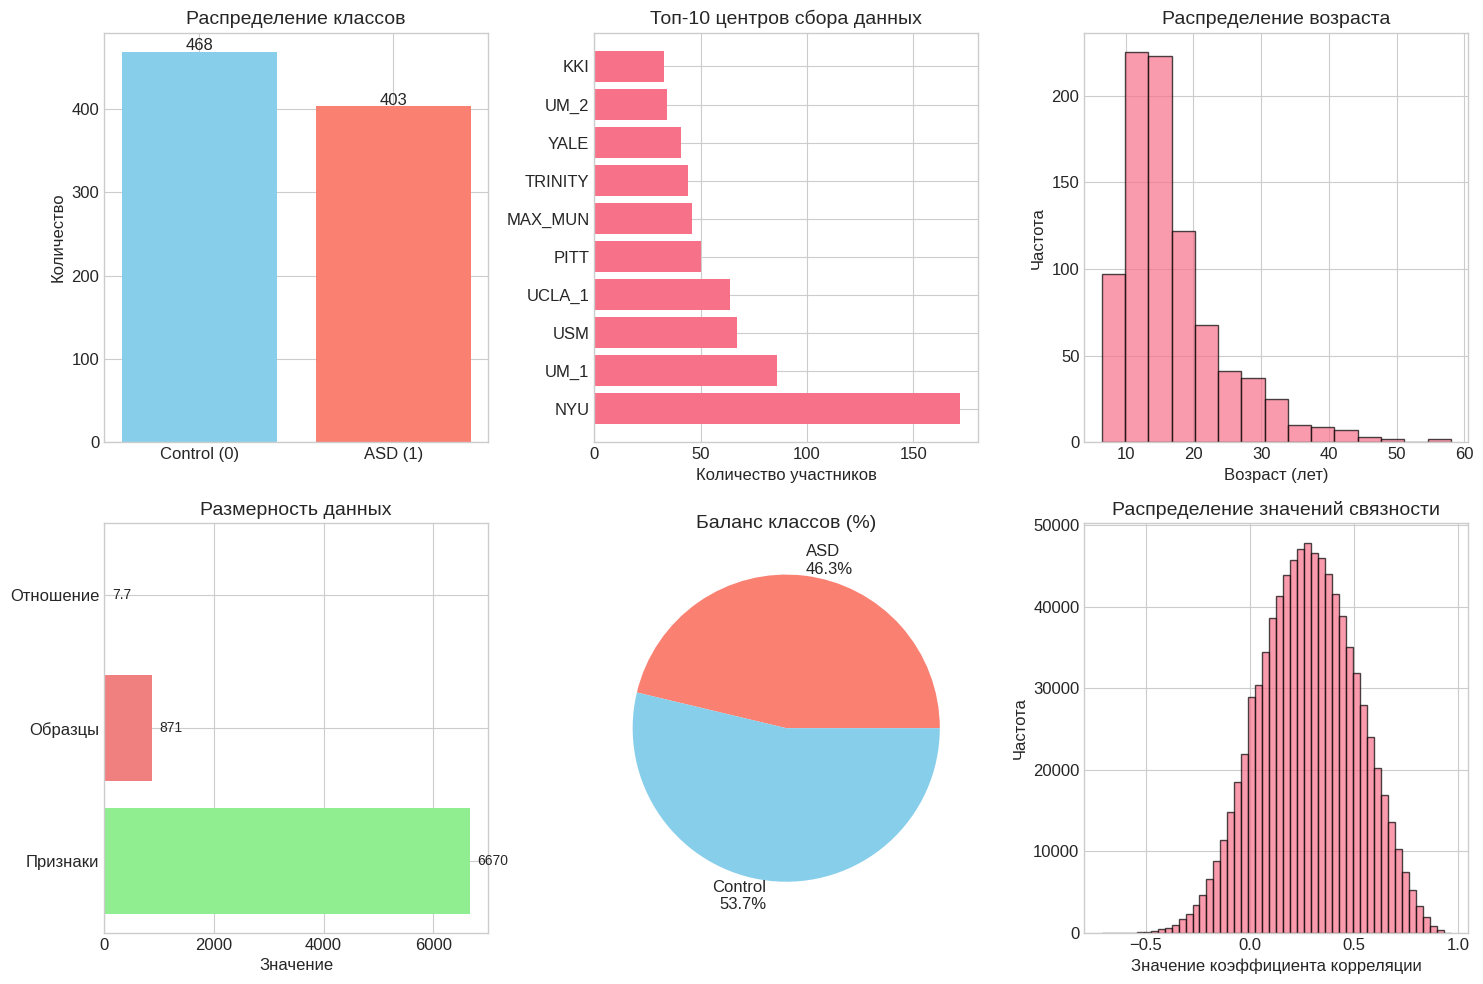


СТАТИСТИКА ДАННЫХ:
Общее количество образцов: 871
Общее количество признаков: 6670
Отношение признаков к образцам: 7.658
Класс ASD: 403 (46.3%)
Класс Control: 468 (53.7%)
Количество уникальных центров: 20
Возраст: 6.5 - 58.0 лет
Средний возраст: 16.9 ± 7.6 лет

ОБЩАЯ СТАТИСТИКА ДАННЫХ:
   Общее количество образцов: 871
   Общее количество признаков: 6670
   Баланс классов: ASD=403 (46.3%), Control=468 (53.7%)
   Количество уникальных сайтов: 20

НАЧАЛО ОЦЕНКИ МОДЕЛЕЙ

______________________________________________________________________
LOGISTIC REGRESSION (БЕЗ DATA LEAKAGE)
______________________________________________________________________

Фолд 1/5:
----------------------------------------
   Отбор признаков (цель: 60)...
   Итоговое количество признаков: 60
   Обучение СИЛЬНО регуляризованной Logistic Regression...

Фолд 2/5:
----------------------------------------
   Отбор признаков (цель: 60)...
   Итоговое количество признаков: 60
   Обучение СИЛЬНО регуляризованной Logist

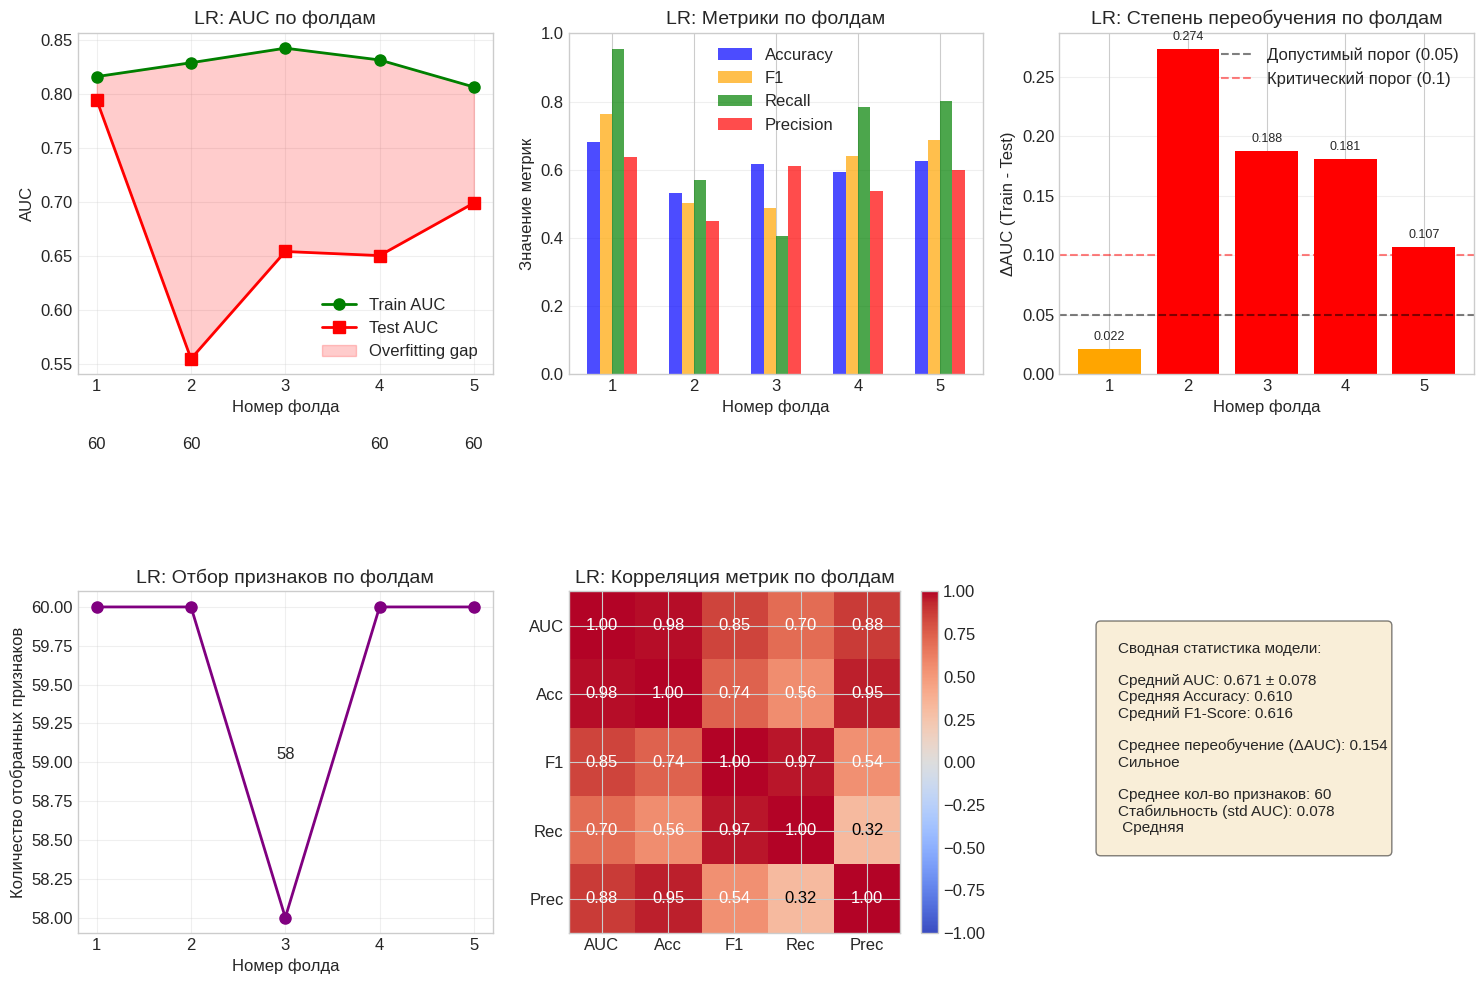

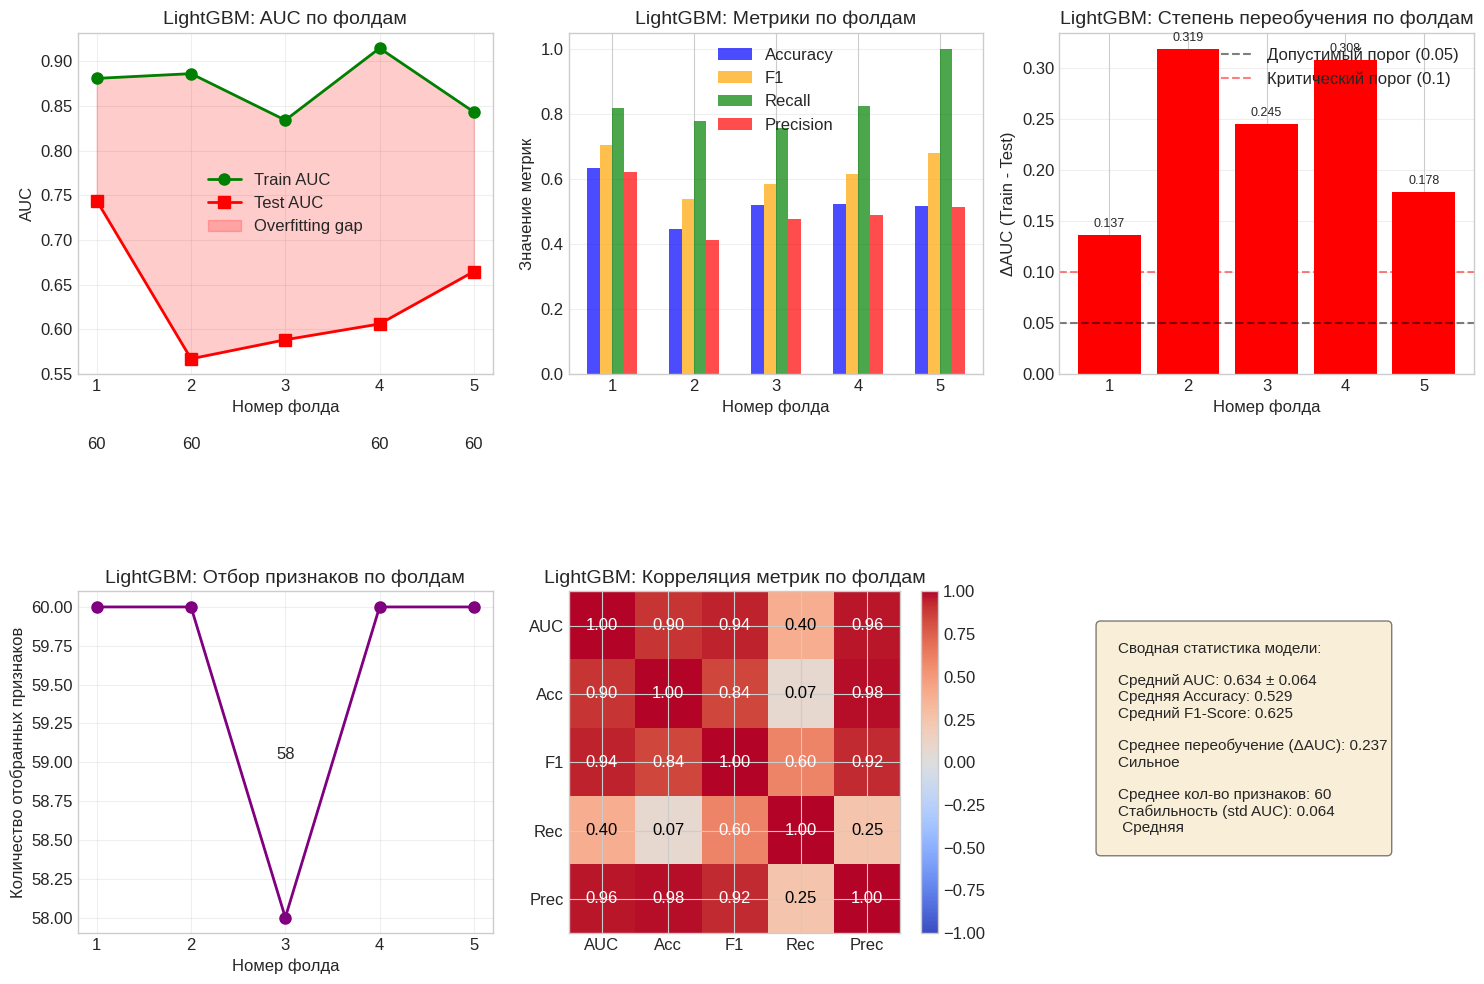

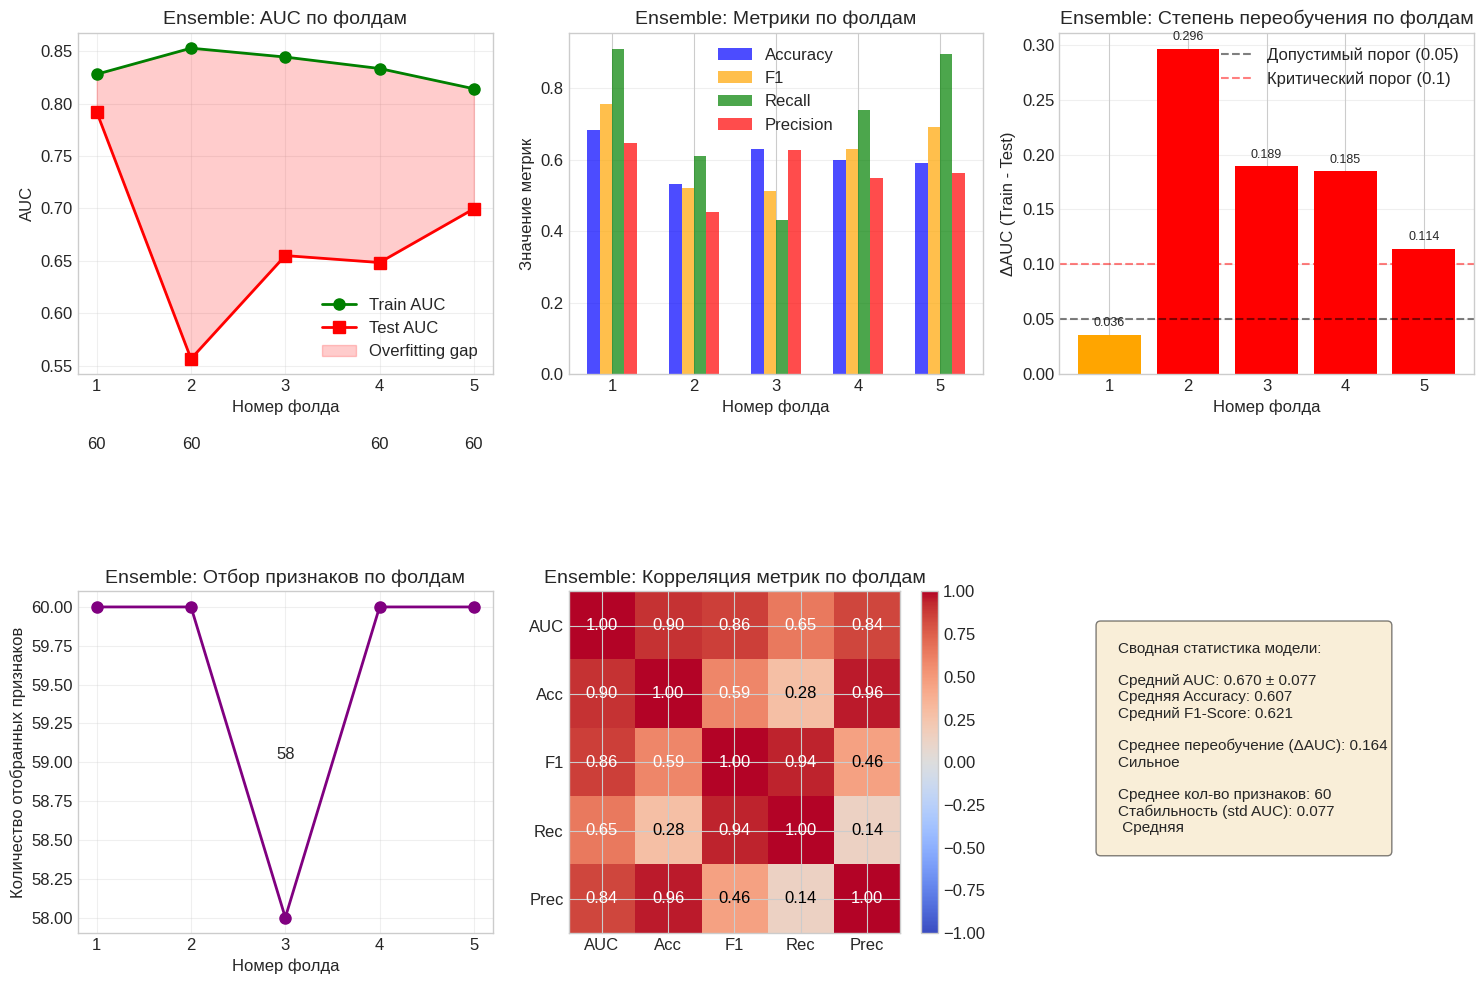


СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ МОДЕЛЕЙ


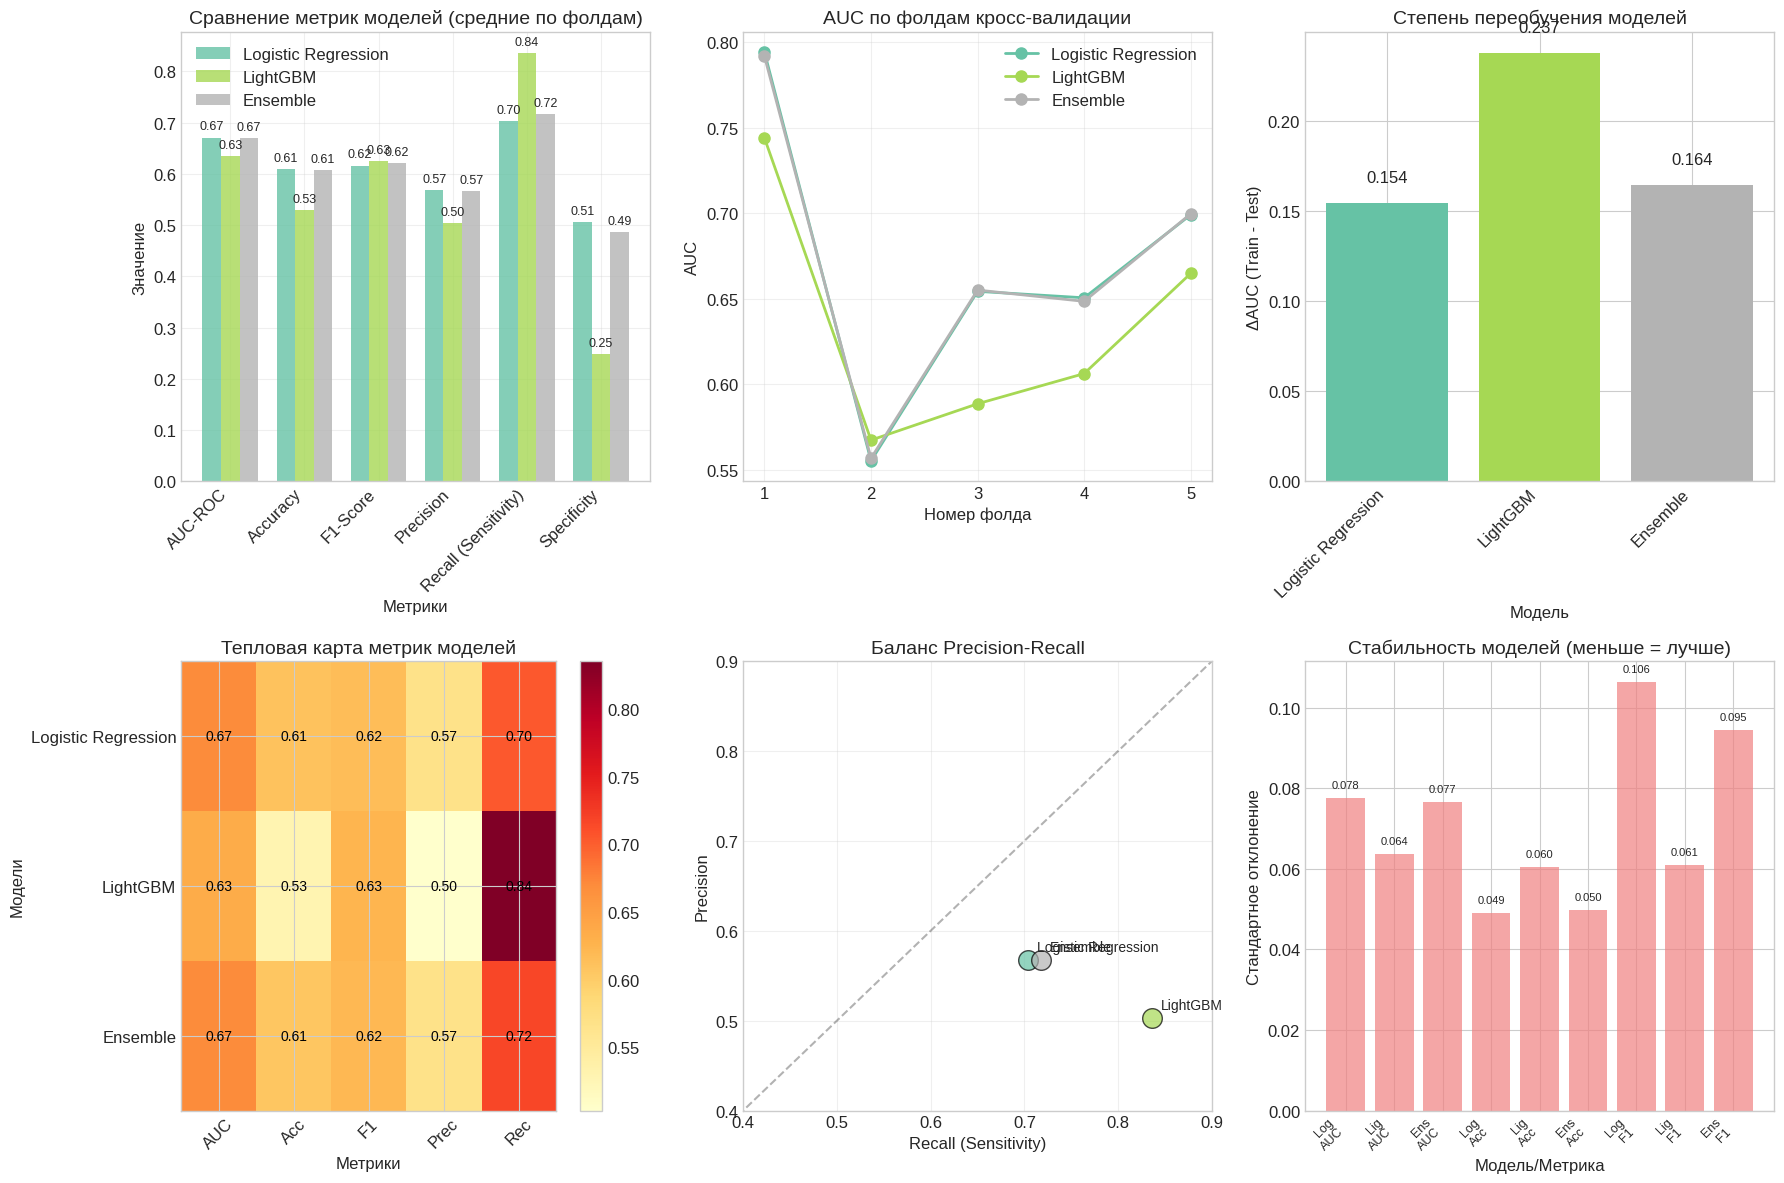


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

Сводная таблица результатов (средние по фолдам):
-----------------------------------------------------------------------------------------------
                Модель   AUC  Accuracy    F1  Recall  Precision  Specificity  ΔAUC
0  Logistic Regression 0.671     0.610 0.616   0.703      0.568        0.506 0.154
1             LightGBM 0.634     0.529 0.625   0.836      0.503        0.248 0.237
2             Ensemble 0.670     0.607 0.621   0.717      0.567        0.487 0.164
-----------------------------------------------------------------------------------------------

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
 Сводная таблица сохранена в 'model_results_summary.csv'
 Детальные результаты сохранены в 'detailed_results.json'

ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!
Созданы следующие графики:
1. data_statistics.png - статистика данных
2. fold_results_Logistic_Regression.png - результаты по фолдам (LR)
3. fold_results_LightGBM.png - результаты по фолдам (LGBM)
4. fold_results_Ensemble.png - ре

In [ ]:
# === ЗАПУСК ПАЙПЛАЙНА ===
if __name__ == "__main__":
    print("ЗАПУСК ПАЙПЛАЙНА С ВИЗУАЛИЗАЦИЯМИ...")
    print("Создание графиков для НИР...\n")

    result = run_all_models_pipeline(n_splits=5, random_state=42)

    if result['success']:
        print("\n" + "=" * 80)
        print("ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!")
        print("Созданы следующие графики:")
        print("1. data_statistics.png - статистика данных")
        print("2. fold_results_Logistic_Regression.png - результаты по фолдам (LR)")
        print("3. fold_results_LightGBM.png - результаты по фолдам (LGBM)")
        print("4. fold_results_Ensemble.png - результаты по фолдам (ансамбль)")
        print("5. model_comparison.png - сравнение моделей")
        print("=" * 80)
    else:
        print("\n" + "=" * 80)
        print("ПАЙПЛАЙН ЗАВЕРШИЛСЯ С ОШИБКОЙ")
        print("=" * 80)
        print(f"Ошибка: {result.get('error', 'Неизвестная ошибка')}")